<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.sort_index(inplace=True)
print(data.head())
data.info()

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
# Просемплируем данные по одному часу, найдя общее количество заказов в час

data = data.resample('1H').sum()

**Ввод:** Файл содержит 26 496 записей исторических данных о заказах такси в аэропортах. Каждая строка данных описывается 1 количественным признаком - количеством заказов

## Анализ

In [ ]:
# Найдем первую и последнюю дату в данных

print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


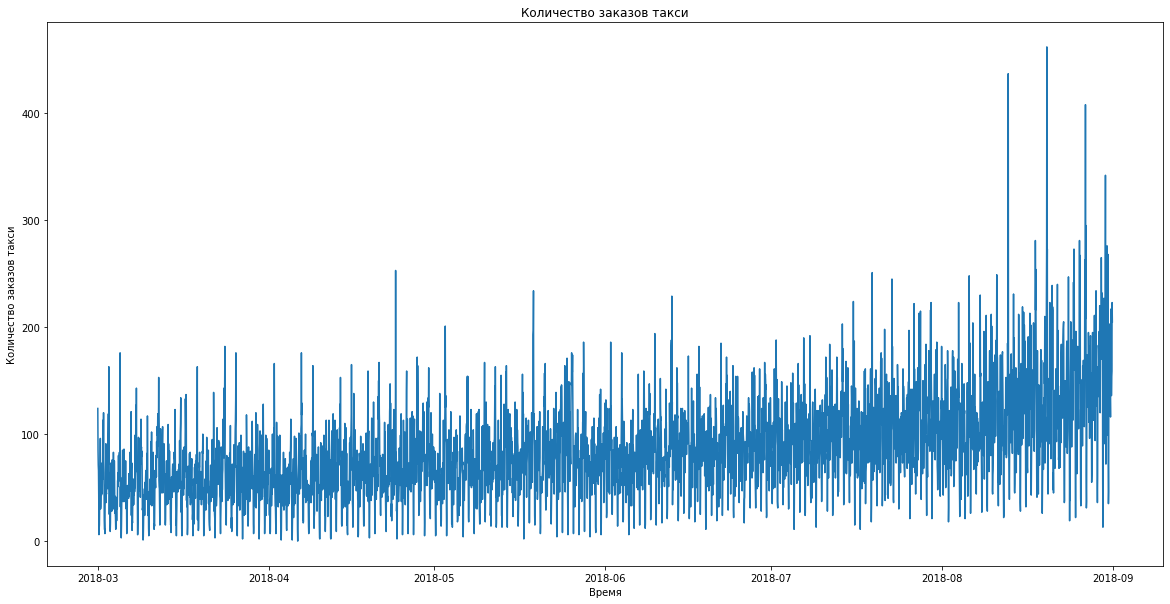

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Количество заказов такси')
plt.ylabel('Количество заказов такси')
plt.xlabel('Время')
plt.plot(data)

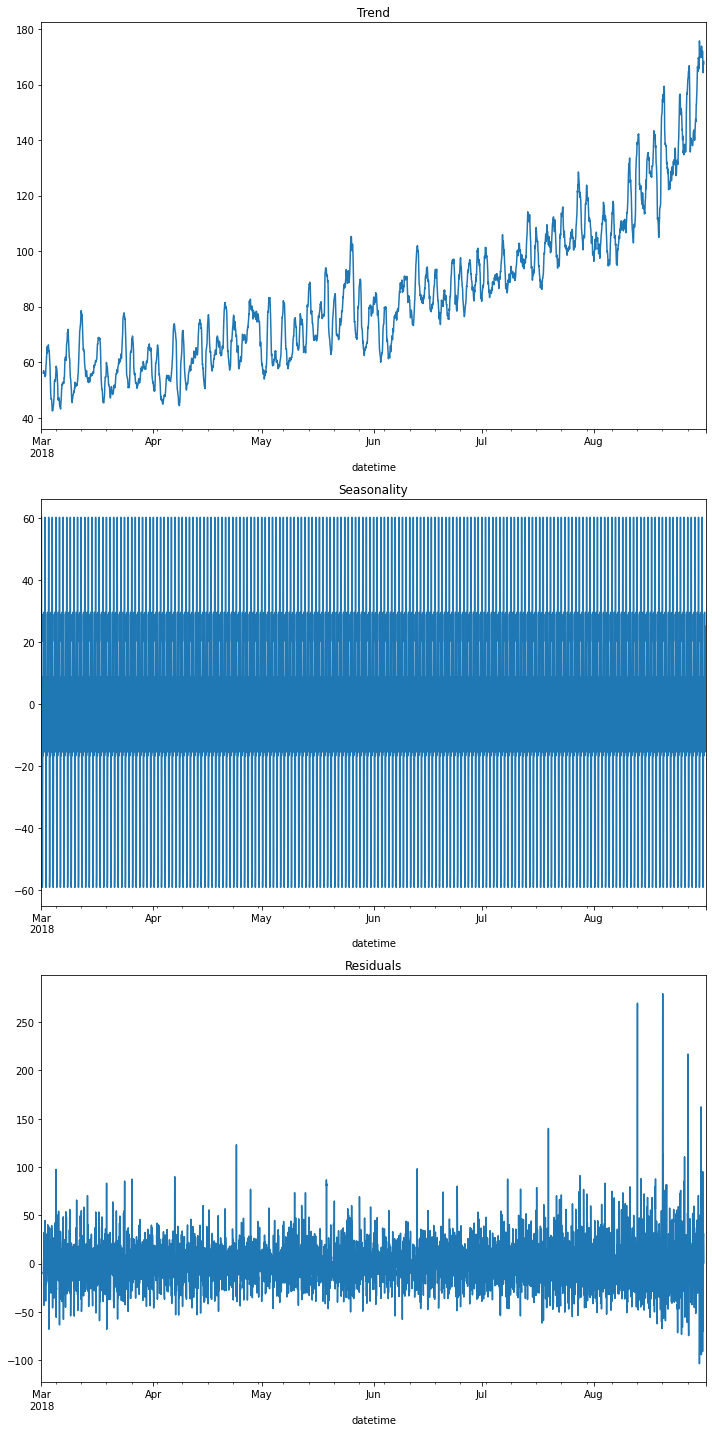

In [ ]:
# Найдем общий тренд в данных
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(10, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [ ]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Рассмотрим данные за последнюю неделю в данных.

<AxesSubplot:title={'center':'Week data'}, xlabel='datetime'>

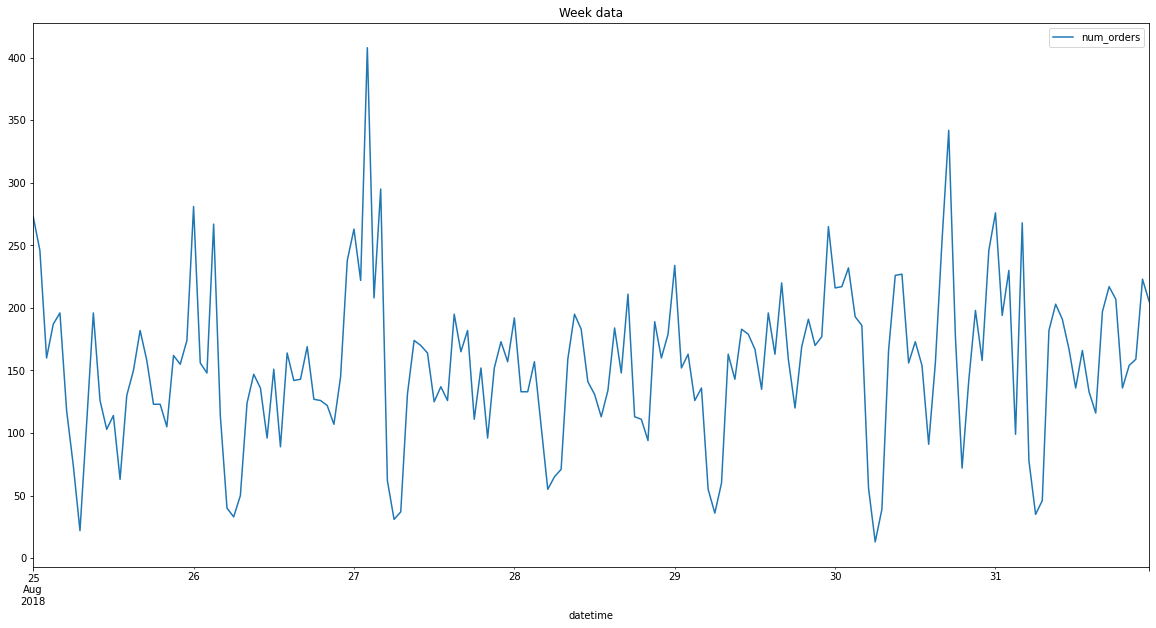

In [ ]:
data['2018-08-25':'2018-08-31'].plot(figsize=(20, 10), title='Week data')

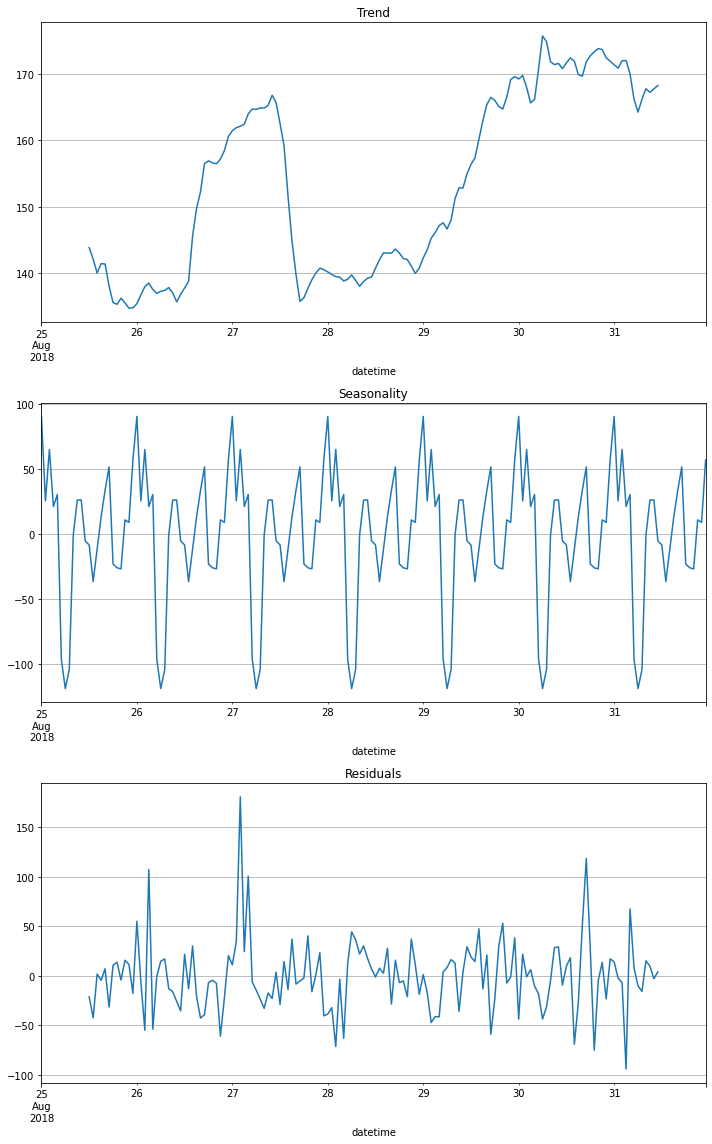

In [ ]:
last_week_data = seasonal_decompose(data['2018-08-25':'2018-08-31'])
plt.figure(figsize=(10, 16))

plt.subplot(311)
last_week_data.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid(True)
plt.subplot(312)
last_week_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)
plt.subplot(313)
last_week_data.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.grid(True)
plt.tight_layout()


Рассмотрим данные за день

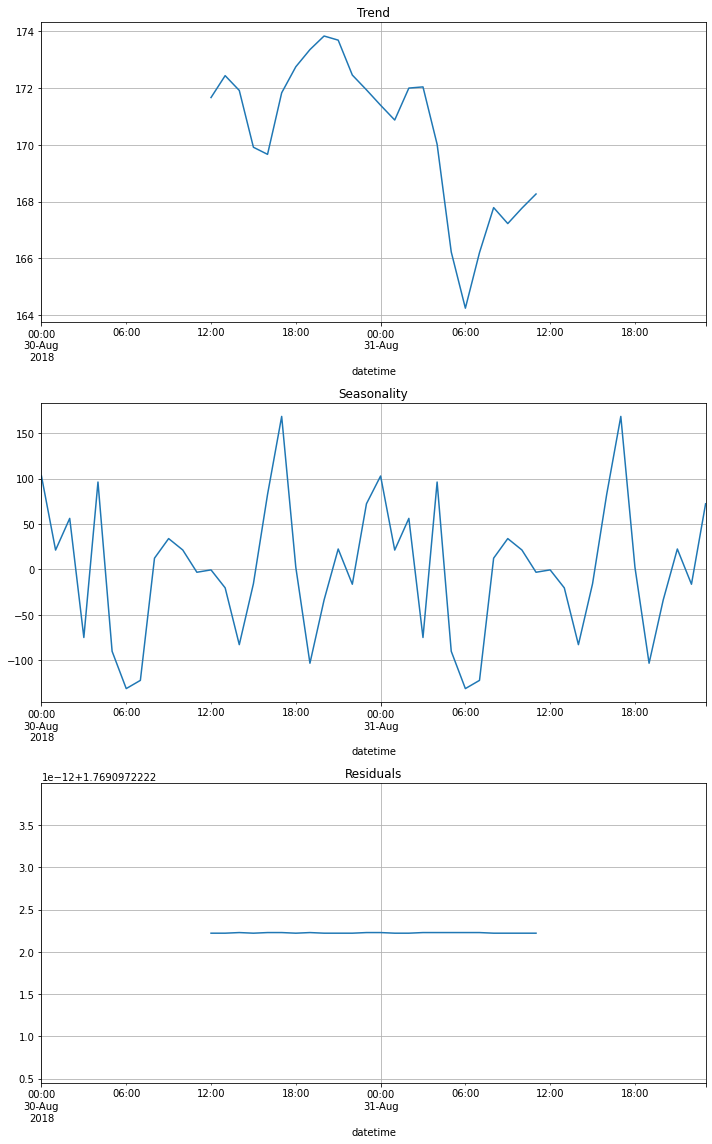

In [ ]:
last_day_data = seasonal_decompose(data['2018-08-30':'2018-08-31'])
plt.figure(figsize=(10, 16))

plt.subplot(311)
last_day_data.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid(True)
plt.subplot(312)
last_day_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)
plt.subplot(313)
last_day_data.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.grid(True)
plt.tight_layout()

**Вывод:** данные предоставляют информацию о количестве заказов такси с первого марта 2018 по 31 августа 2018. Из графика тренда видно, что количество заказов от марта до августа росло. Вероятно, это связано с летними отпусками.

В данных наблюдается сильная частая сезонность. Практически на всем протяжении данных доля остатков примерно одинаковая.
Общий тренд ряда восходящий.
Из недельного тренда можно сделать вывод, что к концу недели (27.08.2018 - воскресенье, 31.08.2018 - пятница) количество заказов такси увеличивается. 
Из сезонности недели и дня видно, что люди чаще вызывают такси в вечерние и ночные часы.

## Обучение

Напишем функцию для получения признаков

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(data, 20, 10)

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(['num_orders'],axis=1)
test_features = test.drop(['num_orders'],axis=1)
train_target = train['num_orders']
test_target = test['num_orders']

Для анализа возьмем модели: Linear Regression, Decision Tree, Ridge, CatBoost

In [ ]:
%%time

slr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
cv_results = cross_validate(slr, train_features, train_target, cv=tscv, 
                         scoring='neg_root_mean_squared_error')
final_score_slr = cv_results['test_score'].mean()
print('Final score:  {:.3f}'.format(final_score_slr))

Final score:  -32.291
CPU times: user 391 ms, sys: 600 ms, total: 991 ms
Wall time: 905 ms


In [ ]:
%%time

#Дерево решений
dtr = DecisionTreeRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=5).split(train_features)
parametrs = { 'min_samples_leaf': [1, 2, 3],
              'max_depth': [1,3,5]}
grid_dtr = GridSearchCV(dtr, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=2)
grid_dtr.fit(train_features, train_target)
print(grid_dtr.best_params_)
final_score_dtr = grid_dtr.best_score_
print(grid_dtr.best_score_)

{'max_depth': 5, 'min_samples_leaf': 3}
-31.667295076238354
CPU times: user 140 ms, sys: 84.5 ms, total: 225 ms
Wall time: 3.26 s


In [ ]:
%%time

#Ridge регрессия
rdr = Ridge(random_state=12345)
tscv = TimeSeriesSplit(n_splits=5).split(train_features)
parametrs = { 'alpha': [0, 0.1, 1],
              'tol': [0.00001,0.0001,0.001]}
grid_rdr = GridSearchCV(rdr, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=2)
grid_rdr.fit(train_features, train_target)
print(grid_rdr.best_params_)
final_score_rdr = grid_rdr.best_score_
print(grid_rdr.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.59966e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.96639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.095e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.59966e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.96639e-18): result may not be accurate.
  return linalg.solv

{'alpha': 1, 'tol': 1e-05}
-32.29077349352672
CPU times: user 58.4 ms, sys: 36.6 ms, total: 95 ms
Wall time: 496 ms


In [ ]:
%%time

cbr = CatBoostRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=5).split(train_features)
parametrs = { 'learning_rate':[0.1, 0.5, 0.8],
              'depth': [1,3,5]}
grid_cbr = GridSearchCV(cbr,parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=2)
grid_cbr.fit(train_features, train_target)
print(grid_cbr.best_params_)
final_score_cbr = grid_cbr.best_score_
print(grid_cbr.best_score_)

0:	learn: 29.1444994	total: 46.3ms	remaining: 46.2s
1:	learn: 28.6640449	total: 46.6ms	remaining: 23.2s
2:	learn: 28.2263022	total: 46.9ms	remaining: 15.6s
3:	learn: 27.7341109	total: 47.2ms	remaining: 11.7s
4:	learn: 27.3939739	total: 47.5ms	remaining: 9.46s
5:	learn: 27.0939538	total: 47.8ms	remaining: 7.92s
6:	learn: 26.7348160	total: 48.1ms	remaining: 6.83s
7:	learn: 26.3748331	total: 48.5ms	remaining: 6.01s
8:	learn: 26.0872774	total: 48.8ms	remaining: 5.37s
9:	learn: 25.7897245	total: 49.1ms	remaining: 4.86s
10:	learn: 25.5475266	total: 49.4ms	remaining: 4.44s
11:	learn: 25.3441439	total: 49.7ms	remaining: 4.09s
12:	learn: 25.1869191	total: 50ms	remaining: 3.8s
13:	learn: 24.9733231	total: 50.3ms	remaining: 3.54s
14:	learn: 24.7443629	total: 50.5ms	remaining: 3.32s
15:	learn: 24.5573451	total: 50.8ms	remaining: 3.12s
16:	learn: 24.3855756	total: 51.1ms	remaining: 2.95s
17:	learn: 24.2172268	total: 51.3ms	remaining: 2.8s
18:	learn: 24.0752758	total: 51.6ms	remaining: 2.67s
19:	lea

**Вывод:** моделью с лучшей метриков на тренировочной выборке является CatBoost c лучшими параметрами depth=3, learning_rate=0.1

## Тестирование

Найдем метрику для CatBoost на тестовой выборке.

In [ ]:
best_model = CatBoostRegressor(random_state=12345, depth=3, learning_rate=0.1)
best_model.fit(train_features, train_target)
predictions = best_model.predict(test_features)
print('RMSE для тестовой выборке',mean_squared_error(test_target, predictions)**0.5)

0:	learn: 37.3080522	total: 2.02ms	remaining: 2.02s
1:	learn: 36.2039033	total: 4.02ms	remaining: 2s
2:	learn: 35.0609132	total: 5.82ms	remaining: 1.93s
3:	learn: 34.1762863	total: 7.82ms	remaining: 1.95s
4:	learn: 33.3432666	total: 9.6ms	remaining: 1.91s
5:	learn: 32.6814097	total: 11.4ms	remaining: 1.89s
6:	learn: 32.0525558	total: 13.1ms	remaining: 1.86s
7:	learn: 31.6689798	total: 15ms	remaining: 1.86s
8:	learn: 31.1842203	total: 16.6ms	remaining: 1.82s
9:	learn: 30.6805744	total: 18.5ms	remaining: 1.83s
10:	learn: 30.3777287	total: 20.3ms	remaining: 1.82s
11:	learn: 30.0388279	total: 22.1ms	remaining: 1.82s
12:	learn: 29.6707092	total: 24ms	remaining: 1.82s
13:	learn: 29.3344409	total: 25.7ms	remaining: 1.81s
14:	learn: 29.0409478	total: 27.8ms	remaining: 1.82s
15:	learn: 28.7997720	total: 29.6ms	remaining: 1.82s
16:	learn: 28.4232587	total: 31.5ms	remaining: 1.82s
17:	learn: 28.2309657	total: 33.3ms	remaining: 1.81s
18:	learn: 28.0457064	total: 35ms	remaining: 1.8s
19:	learn: 27.

RMSE для тестовой выборке = 42.89, что меньше масимума, указанного в условиях задачи. Сравним полученную метрику с метрикой простейшей модели.

In [ ]:
model_dummy_regressor = DummyRegressor()
model_dummy_regressor.fit(train_features, train_target)
predictions_test_dummy = model_dummy_regressor.predict(test_features)
print("Тестовая выборка для сырья:", mean_squared_error(test_target, predictions_test_dummy)**0.5)

Тестовая выборка для сырья: 84.6528030070785


In [ ]:
pred_previous = test_target.shift()
pred_previous.iloc[0] = train_target.iloc[-1]

print("Тестовая выборка для сырья:", mean_squared_error(test_target, pred_previous)**0.5)

Тестовая выборка для сырья: 58.856486242815066


**Вывод:** Выбранная лучшая модель была проверена на тестовой выборке. Ее метрика меньше максимума в условиях задания и меньше метрики простейших моделей.

## Вывод


В данном проекте нужно было построить модель для предсказаниях заказов такси в аэропортах, осноываясь на исторических данных.

Файл содержит 26 496 записей исторических данных о заказах такси в аэропортах. Каждая строка данных описывается 1 количественным признаком - количеством заказов. Данные были просемплированы по одному часу.

Данные предоставляют информацию о количестве заказов такси с первого марта 2018 по 31 августа 2018. Из графика тренда видно, что количество заказов от марта до августа росло. Вероятно, это связано с летними отпусками.В данных наблюдается сильная частая сезонность. Практически на всем протяжении данных доля остатков примерно одинаковая. Общий тренд ряда восходящий. Из недельного тренда можно сделать вывод, что к концу недели (27.08.2018 - воскресенье, 31.08.2018 - пятница) количество заказов такси увеличивается. Из сезонности недели и дня видно, что люди чаще вызывают такси в вечерние и ночные часы.

Была написана функция для получения признаков для дальнейшего обучения. Для анализа были выбраны модели: Linear Regression, Decision Tree, Ridge, CatBoost. Они показали следующие метрики RMSE на тренировочной выборке:

* Linear Regression: 29.54
* Decision Tree: 29.12
* Ridge: 29.54
* CatBoost: 23.41

Моделью с лучшей метрикой на тренировочной выборке является CatBoost

RMSE для тестовой выборки = 43.87, что меньше масимума (48), указанного в условиях задачи. Выбранная лучшая модель была сравнена с простейшей моделью, метрика которой 84.65